<a href="https://colab.research.google.com/github/nda111/Multimedia2021-1_ImageColorization/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing for Dataset
## Unzip the data archive.
Upzip the zipped dataset file.

In [14]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
import os
import zipfile
import tqdm

unzipped_flag = './unzip.done'
file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive', file_name)

if os.path.exists(unzipped_flag):
  print('Dataset already unzipped.')
elif os.path.exists(zip_path):
  !cp "{zip_path}" .
  !unzip -q "{file_name}"
  !rm "{file_name}"
  !touch "{unzipped_flag}"
  print('Dataset unzipped.')
else:
  print('File not exists:', zip_path)

Dataset already unzipped.


## Color-hint Transform

If you want to change how many hints you are giving, change the threshold values in call function.



In [16]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import cv2
import random
import numpy as np

class ColorHintTransform(object):
  def __init__(self, size=256, mode="training"):
    super(ColorHintTransform, self).__init__()
    self.size = size
    self.mode = mode
    self.transform = transforms.Compose([transforms.ToTensor()])

  def bgr_to_lab(self, img):
      lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
      l, ab = lab[:, :, 0], lab[:, :, 1:]
      return l, ab
  
  def hint_mask(self, bgr, threshold=[0.95, 0.97, 0.99]):
    h, w, c = bgr.shape
    mask_threshold = random.choice(threshold)
    mask = np.random.random([h, w, 1]) > threshold
    return mask

  def __call__(self, img):
    threshold = [0.95, 0.97, 0.99]
    if (self.mode == "training") | (self.mode == "validation"):
      image = cv2.resize(img, (self.size, self.size))
      mask = self.hint_mask(image, threshold)

      hint_image = image * mask
      
      l, ab = self.bgr_to_lab(image)
      l_hint, ab_hint = self.bgr_to_lab(hint_image)

      return self.transform(l), self.transform(ab), self.transform(ab_hint)

    elif self.mode == "testing":
      image = cv2.resize(img, (self.size, self.size))

      l, ab = self.bgr_to_lab(image)

      return self.gt_transform(l), self.transform(ab)

    else:
      return NotImplementedError


# DataLoader for Colorization Dataset

In [17]:
import torch
import torch.utils.data  as data
import os
import cv2
from google.colab.patches import cv2_imshow

class ColorHintDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(ColorHintDataset, self).__init__()
 
    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None
 
  def set_mode(self, mode):
    self.mode = mode
    self.transforms = ColorHintTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "test")
      self.examples = [os.path.join(self.root_path, "test", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)
 
  def __getitem__(self, idx):
    file_name = self.examples[idx]
    img = cv2.imread(file_name)

    if self.mode == "testing":
      input_l, input_ab = self.transforms(img)
      sample = {"l": input_l, "ab": input_ab}
    else:
      l, ab, hint = self.transforms(img)
      sample = {"l": l, "ab": ab, "hint": hint}
 
    return sample

## Example for DataLoader


  0%|          | 0/1125 [00:00<?, ?it/s]

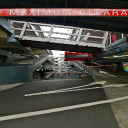

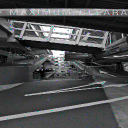

  0%|          | 0/1125 [00:00<?, ?it/s]


In [18]:
import torch
import torch.utils.data  as data
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image
import numpy as np

def tensor2im(input_image, imtype=np.uint8):
  if isinstance(input_image, torch.Tensor):
      image_tensor = input_image.data
  else:
      return input_image
  image_numpy = image_tensor[0].cpu().float().numpy()
  if image_numpy.shape[0] == 1:
      image_numpy = np.tile(image_numpy, (3, 1, 1))
  image_numpy = np.clip((np.transpose(image_numpy, (1, 2, 0)) ),0, 1) * 255.0
  return image_numpy.astype(imtype)

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = ColorHintDataset(root_path, 128)
train_dataset.set_mode("training")

val_dataset = ColorHintDataset(root_path, 128)
val_dataset.set_mode('validation')

train_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

for i, data in enumerate(tqdm.tqdm(train_dataloader)):
  if use_cuda:
    l = data["l"].to('cuda')
    ab = data["ab"].to('cuda')
    hint = data["hint"].to('cuda')
  
  gt_image = torch.cat((l, ab), dim=1)
  hint_image = torch.cat((l, hint), dim=1)

  gt_np = tensor2im(gt_image)
  hint_np = tensor2im(hint_image)

  gt_bgr = cv2.cvtColor(gt_np, cv2.COLOR_LAB2BGR)
  hint_bgr = cv2.cvtColor(hint_np, cv2.COLOR_LAB2BGR)
  
  cv2_imshow(gt_bgr)
  cv2_imshow(hint_bgr)
  break

#Colorization Model

## TODO: Build Model

In [23]:
import torch
import torch.nn as nn
import torchvision


class ColorizationModel(nn.Module):
  def __init__(self):
    super(ColorizationModel, self).__init__()
    
    self.conv = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=1)
    
  def forward(self, x):
    x = self.conv(x)

    return x


model = ColorizationModel()
test_X = torch.rand(4, 3, 128, 128)
test_y = model(test_X)
print(' in:', test_X.shape) # (4, 3, 128, 128)
print('out:', test_y.shape) # (4, 2, 128, 128)

 in: torch.Size([4, 3, 128, 128])
out: torch.Size([4, 2, 128, 128])


#Training Section

In [24]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import os

use_cuda = True
device = 'cuda' if use_cuda and torch.cuda.is_available() else 'cpu'
print('Device:', device)

num_epochs = 20
learning_rate = 1.0E-2

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=5.0E-1)

save_path = './ColorizationModel'
state_dict_path = os.path.join(save_path, 'colorization_model.tar')

os.makedirs(save_path, exist_ok=True)

Device: cuda


In [ ]:
import torch
import numpy as np
import tqdm
import cv2


def train_epoch(model, dataloader):
  model.train()

  total_loss = 0
  for sample in tqdm.auto.tqdm(dataloader):
    hint = torch.cat([sample['l'], sample['hint']], dim=1).to(device)
    gt = sample['ab'].to(device)

    hypothesis = model(hint)
    loss = criterion(hypothesis, gt)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.detach()

  total_loss /= len(dataloader)
  return total_loss.item()

def validate_epoch(model, dataloader):
  model.eval()

  total_loss = 0
  for sample in tqdm.auto.tqdm(dataloader):
    hint = torch.cat([sample['l'], sample['hint']], dim=1).to(device)
    gt = sample['ab'].to(device)

    hypothesis = model(hint)
    loss = criterion(hypothesis, gt)

    total_loss += loss.detach()
  
  total_loss /= len(dataloader)
  return total_loss.item()


model = ColorizationModel().to(device)
for param in model.parameters():
  if param.ndim != 1:
    init.kaiming_normal_(param)

min_loss = np.inf
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
  print(f'[Epoch {epoch + 1}/{num_epochs}]')

  train_loss = train_epoch(model, train_dataloader)
  val_loss = validate_epoch(model, val_dataloader)
  print(f'     Train loss={train_loss}')
  print(f'Validation loss={val_loss}\n')

  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  if val_loss < min_loss:
    min_loss = val_loss
    state_dict = {
        'note': 'ColorizationModel',
        'loss': val_loss,
        'state': model.state_dict(),
    }
    torch.save(state_dict, state_dict_path)

[Epoch 1/20]



     Train loss=0.4043765664100647
Validation loss=0.4041786193847656

[Epoch 2/20]



     Train loss=0.4043613076210022
Validation loss=0.40421444177627563

[Epoch 3/20]



     Train loss=0.4043568968772888
Validation loss=0.4041968882083893

[Epoch 4/20]



     Train loss=0.40437081456184387
Validation loss=0.40418997406959534

[Epoch 5/20]



     Train loss=0.4043561518192291
Validation loss=0.4041869640350342

[Epoch 6/20]



     Train loss=0.4043690860271454
Validation loss=0.4042207896709442

[Epoch 7/20]



     Train loss=0.40438228845596313
Validation loss=0.40422338247299194

[Epoch 8/20]



     Train loss=0.4043741524219513
Validation loss=0.40421348810195923

[Epoch 9/20]


## Visualize Result

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

done_epochs = len(train_loss_list)
epoch_axis = range(done_epochs)
plt.title('LOSS')
plt.plot(
    epoch_axis, train_loss_list, 
    epoch_axis, val_loss_list,
    [0, num_epochs - 1], [min_loss, min_loss], 'r-')
plt.legend(['Train', 'Validation'])
plt.show()
print()

train_loss_list = np.array(train_loss_list)
print('[TRAIN]')
m = np.mean(train_loss_list)
s = np.mean((train_loss_list - m) ** 2)
print(f'Mean={m}\nVariance={s}\n')

val_loss_list = np.array(val_loss_list)
print('[VALIDATION]')
m = np.mean(val_loss_list)
s = np.mean((val_loss_list - m) ** 2)
print(f'Mean={m}\nVariance={s}')

In [ ]:
import torch

state_dict = torch.load(state_dict_path)
model = ColorizationModel().cuda()
model.load_state_dict(state_dict['state'], strict=True)
print('Validation loss:', state_dict['loss'])

with torch.no_grad():
  model.eval()

  gray_ab = torch.ones(1, 2, 128, 128) * 0.5

  num_batches = len(val_dataloader)
  num_samples = min(num_batches, 10)
  for idx, sample in enumerate(val_dataloader):
    if idx == num_samples:
      break
    print(f'{idx + 1}/{num_samples}({num_batches})')

    gray = torch.cat([sample['l'], gray_ab], dim=1).to(device)
    hint = torch.cat([sample['l'], sample['hint']], dim=1).to(device)
    truth = torch.cat([sample['l'], sample['ab']], dim=1).to(device)
    pred = torch.cat([sample['l'], model(hint).cpu()], dim=1).to(device)

    def img_show(image):
      image = tensor2im(image)
      image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
      cv2_imshow(image)

    img_show(gray)
    img_show(hint)
    img_show(truth)
    img_show(pred)
    print()